In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
import shap


c:\Users\lackerman008\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from config_and_logging import load_config
from data_loading import load_data

config = load_config()

print(config.get("models", {}))
train_df, test_df, sample_submission = load_data(config)
target_column = config['data']['target_column']

[{'type': 'LinearRegression', 'params': {}}, {'type': 'RandomForest', 'params': {'n_estimators': 10, 'random_state': 42}}]


In [5]:

from preprocessing import get_imputer, create_preprocessing_pipeline
# Create preprocessing pipeline with your preferred imputation method
pipeline = create_preprocessing_pipeline(
    imputer     = get_imputer(config),
    freq        = config['preprocessing']['freq'],
    fill_method = config['preprocessing']['fill_method']
)
# Fit the pipeline on training data
pipeline.fit(train_df)

# Transform both training and test data
train_processed = pipeline.transform(train_df)
test_processed = pipeline.transform(test_df)

c:\Users\lackerman008\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\lackerman008\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [6]:
features = [col for col in train_processed.columns if col != target_column]

X = train_processed[features].copy()
y = train_processed[target_column].copy()

In [7]:
train_processed.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h,Valencia_wind_deg_cat,Seville_pressure_cat
2015-01-01 03:00:00,0.666667,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,223.333333,6.333333,...,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667,5.0,25.0
2015-01-01 06:00:00,0.333333,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,221.000000,4.000000,...,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667,10.0,25.0
2015-01-01 09:00:00,1.000000,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,214.333333,2.000000,...,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667,9.0,25.0
2015-01-01 12:00:00,1.000000,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,199.666667,2.333333,...,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667,8.0,25.0
2015-01-01 15:00:00,1.000000,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,185.000000,4.333333,...,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667,7.0,25.0


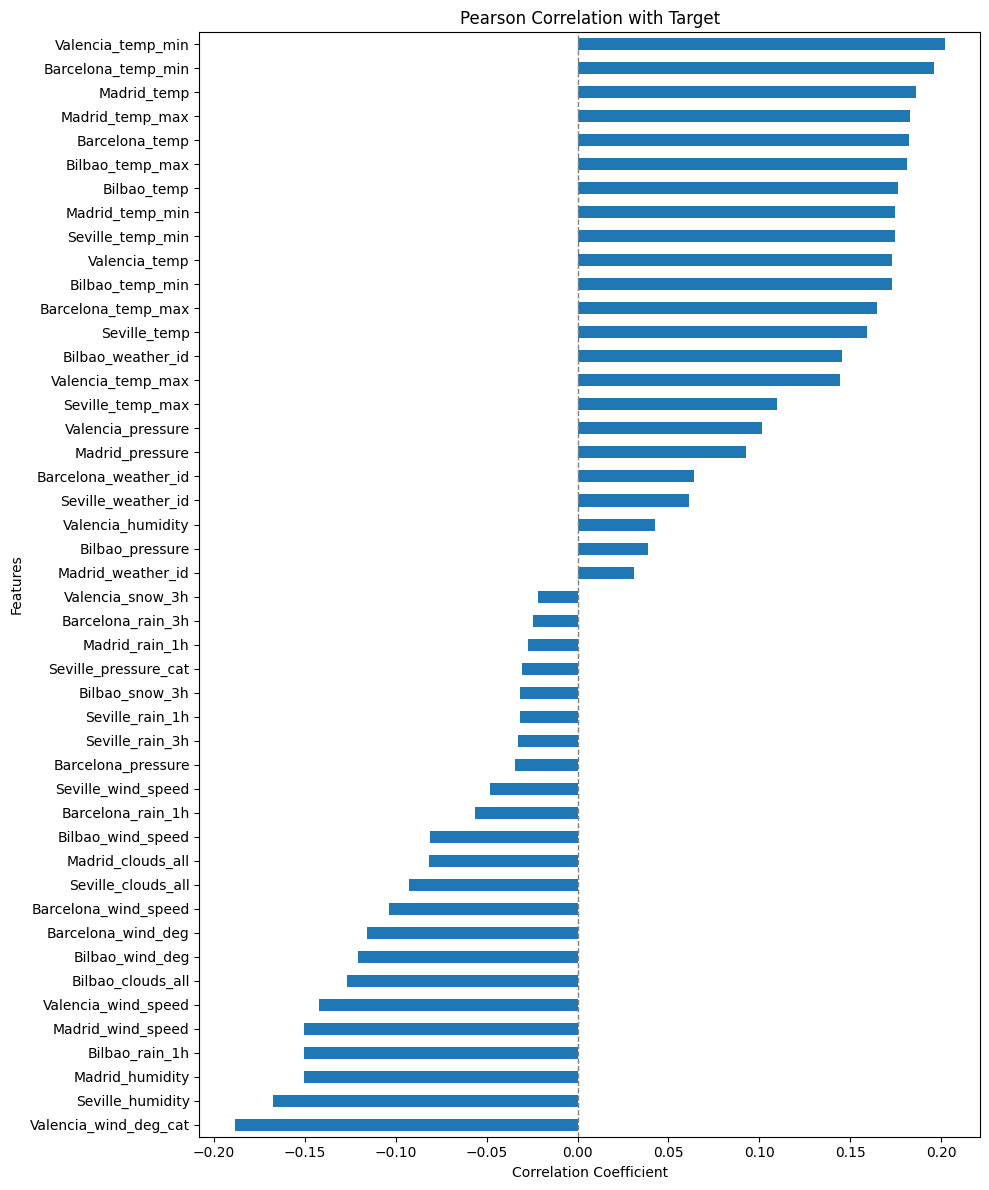

In [8]:
corrs = X.corrwith(y).sort_values()

plt.figure(figsize=(10, 12))
corrs.plot(kind='barh', title='Pearson Correlation with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='grey', lw=1, ls='--')
plt.tight_layout()
plt.show()

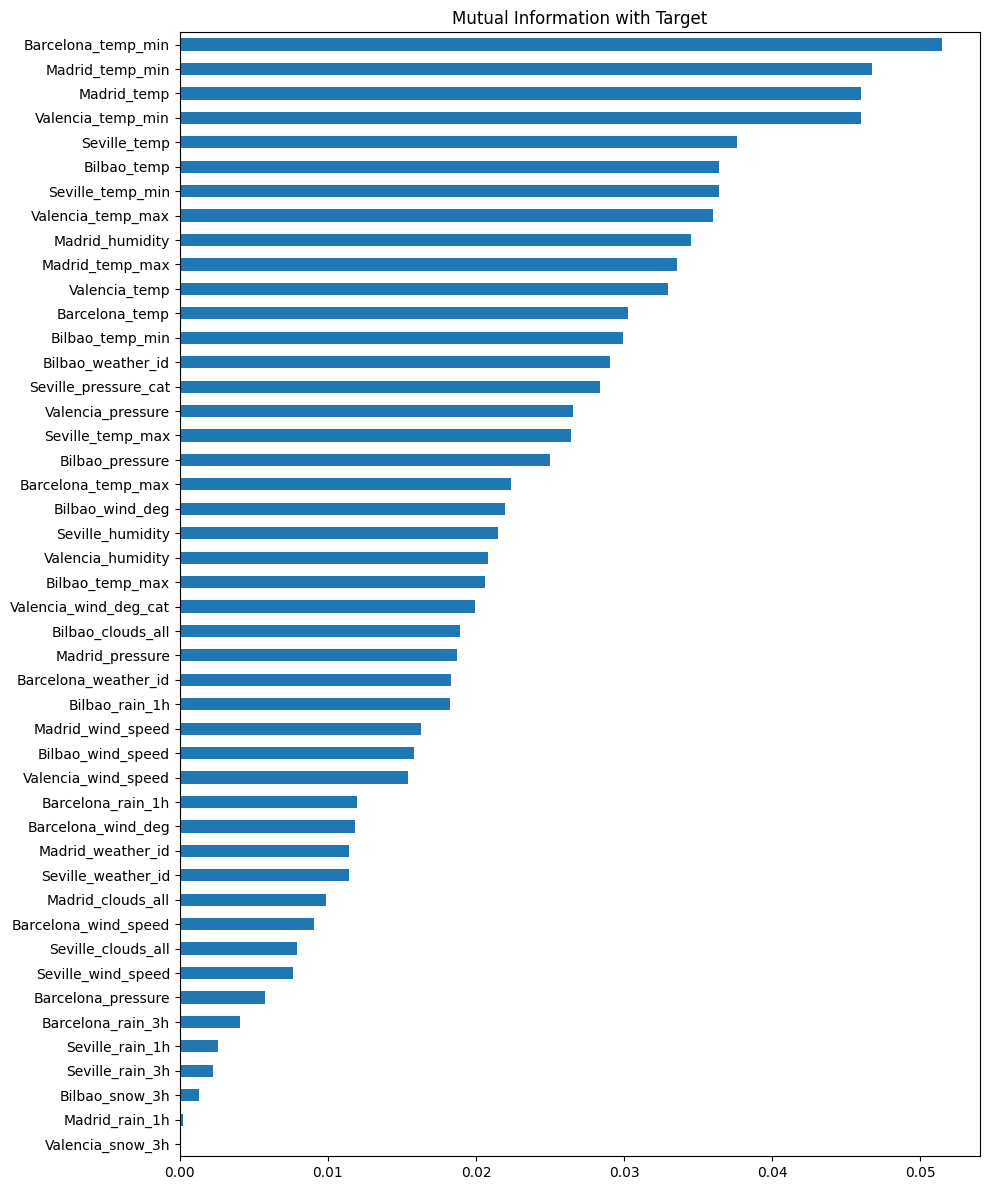

In [9]:
mi_scores = mutual_info_regression(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values()

plt.figure(figsize=(10, 12))
mi_series.plot(kind='barh', title='Mutual Information with Target')
plt.tight_layout()
plt.show()

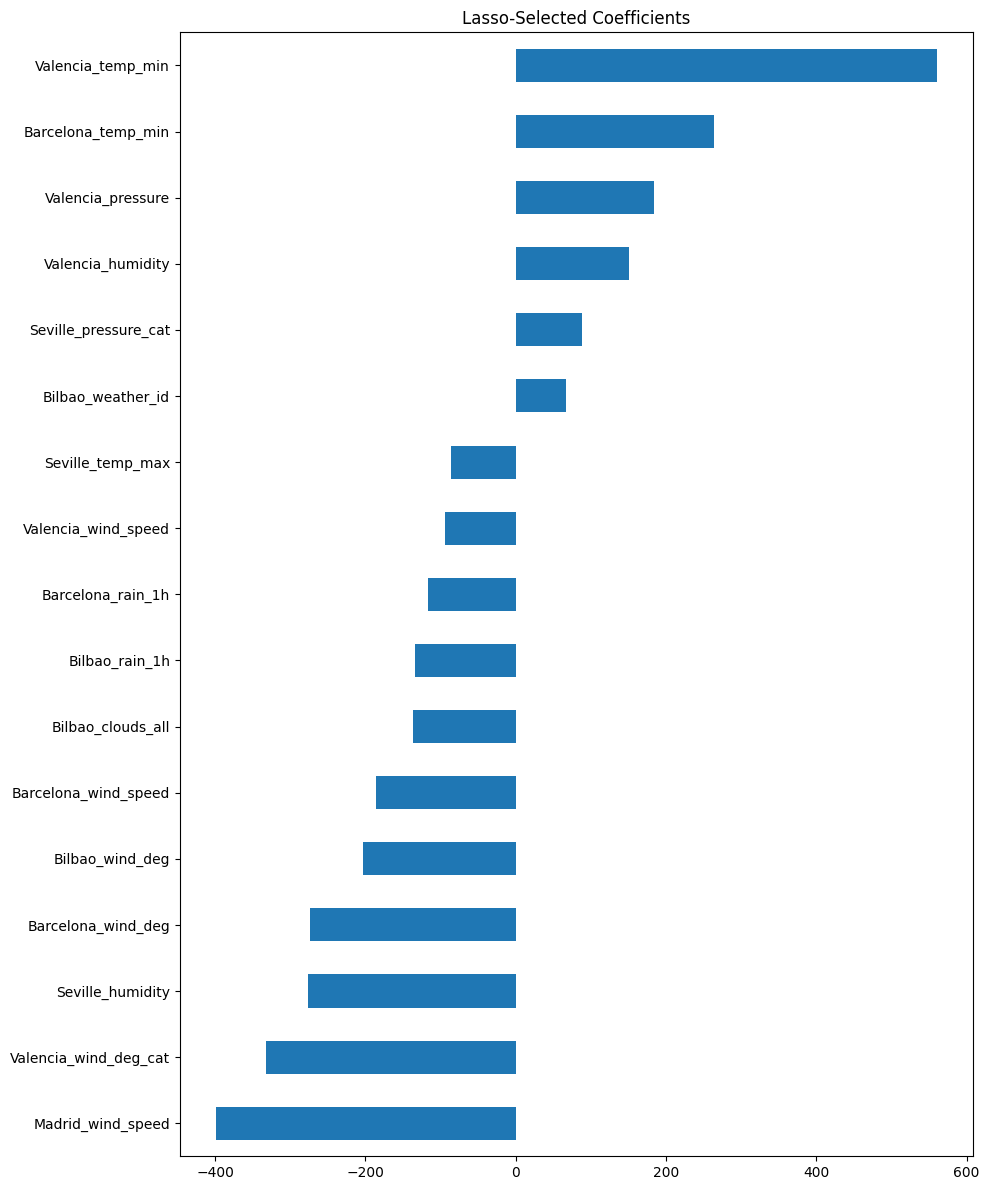

In [10]:
pipe = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=0, max_iter=10000))
pipe.fit(X, y)

lasso = pipe.named_steps['lassocv']
lasso_coefs = pd.Series(lasso.coef_, index=X.columns)
lasso_selected = lasso_coefs[lasso_coefs != 0].sort_values()

plt.figure(figsize=(10, 12))
lasso_selected.plot(kind='barh', title='Lasso-Selected Coefficients')
plt.tight_layout()
plt.show()

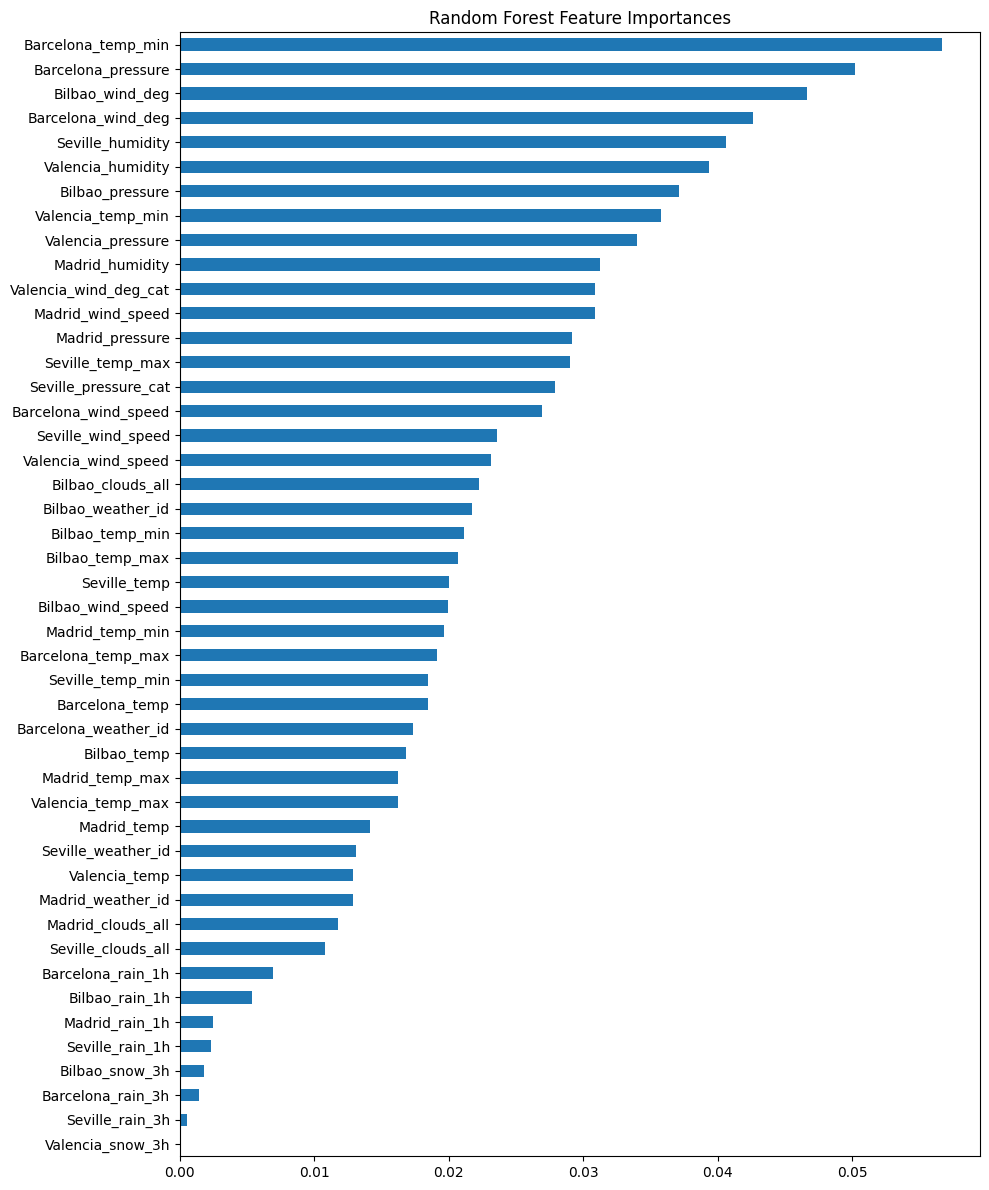

In [11]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X, y)

rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(10, 12))
rf_importance.plot(kind='barh', title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

In [12]:
explainer = shap.Explainer(rf, X)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display=30)

100%|===================| 8765/8767 [47:08<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 64.356977, while the model output was -141.263333. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
summary = pd.DataFrame({
    'Correlation': corrs,
    'Mutual_Info': mi_series,
    'Lasso_Coeff': lasso_coefs,
    'RF_Importance': rf_importance
}).fillna(0)

summary['Combined_Score'] = (
    summary['Mutual_Info'].rank() +
    summary['RF_Importance'].rank() +
    summary['Lasso_Coeff'].abs().rank()
)

summary.sort_values('Combined_Score', ascending=False).head(50)

,Correlation,Mutual_Info,Lasso_Coeff,RF_Importance,Combined_Score
Barcelona_temp_min,0.195793,0.051472,263.617352,0.056654,133.0
Valencia_temp_min,0.201830,0.045987,560.573737,0.035761,128.0
Seville_humidity,-0.167442,0.021519,-276.355699,0.040627,111.0
Bilbao_wind_deg,-0.120572,0.021943,-203.053769,0.046616,111.0
Valencia_pressure,0.101189,0.026551,183.447478,0.034005,107.0
Valencia_wind_deg_cat,-0.188443,0.019939,-332.030884,0.030886,103.0
Valencia_humidity,0.042827,0.020787,150.698910,0.039364,103.0
Barcelona_wind_deg,-0.115944,0.011853,-273.946263,0.042619,99.0
Madrid_wind_speed,-0.150403,0.016322,-398.908722,0.030861,98.0
Seville_pressure_cat,-0.030614,0.028374,87.542092,0.027883,96.0


ADF Statistic: -23.173041807438114
p-value: 0.0
Critical Values: {'1%': -3.431099796556747, '5%': -2.861871360139148, '10%': -2.5669463780359156}


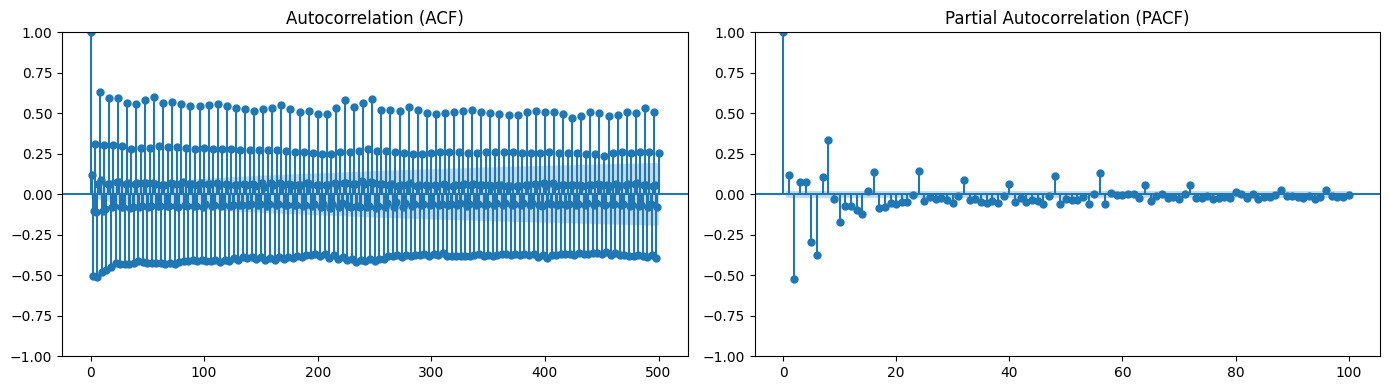

In [22]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_series = train_df[target_column].diff().dropna()

from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
# Plot ACF and PACF side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(diff_series, lags=500, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(diff_series, lags=100, ax=axes[1], method='ywm')
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

# Time dummies
* Cyclical dummies added

c:\Users\lackerman008\OneDrive - pwc\Outside\Code\Machine learning\Electricity Shortfall Challenge\preprocessing.py:400: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  


            hour_block  hour_sin  hour_cos  day_of_week   dow_sin  dow_cos  \
2015-01-05           0       0.0       1.0            0  0.000000  1.00000   
2015-02-02           0       0.0       1.0            0  0.000000  1.00000   
2015-03-02           0       0.0       1.0            0  0.000000  1.00000   
2015-04-06           0       0.0       1.0            0  0.000000  1.00000   
2015-05-04           0       0.0       1.0            0  0.000000  1.00000   
2015-06-01           0       0.0       1.0            0  0.000000  1.00000   
2015-07-06           0       0.0       1.0            0  0.000000  1.00000   
2015-08-03           0       0.0       1.0            0  0.000000  1.00000   
2015-09-07           0       0.0       1.0            0  0.000000  1.00000   
2015-10-05           0       0.0       1.0            0  0.000000  1.00000   
2015-11-02           0       0.0       1.0            0  0.000000  1.00000   
2015-12-07           0       0.0       1.0            0  0.00000

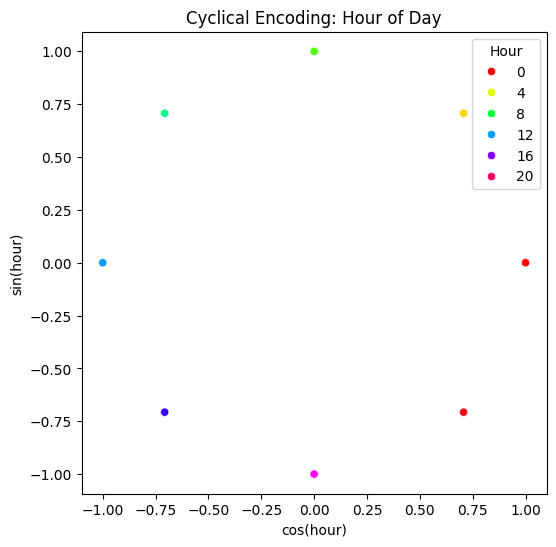

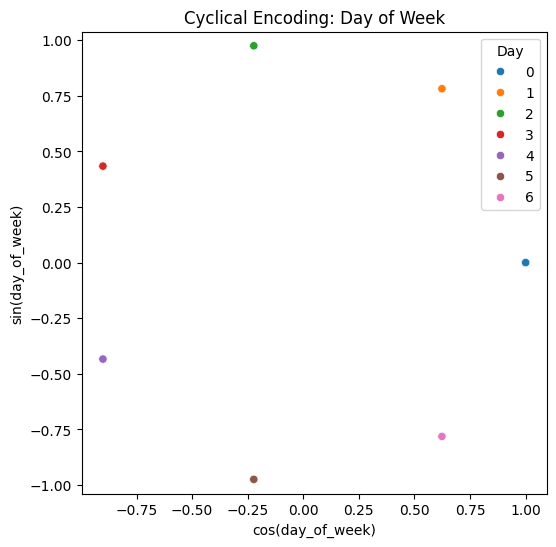

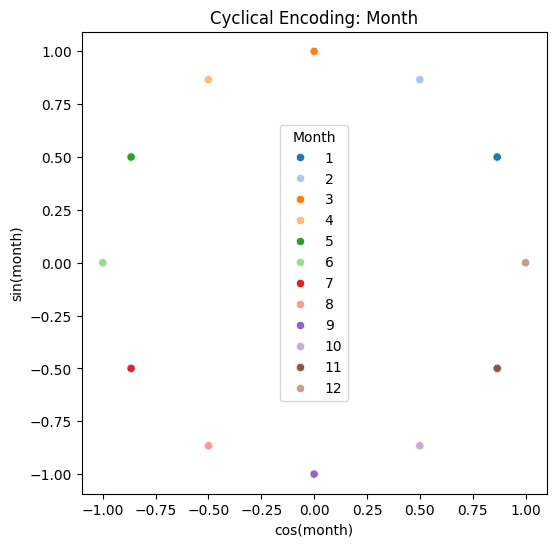

In [23]:
import numpy as np
from data_loading import load_data
from preprocessing import set_datetime_as_index

train_df, test_df, sample_submission = load_data(config)
target_column = config['data']['target_column']
df = train_df.copy()
df = set_datetime_as_index(df)
timestamp_col = 'time'

df['hour_block'] = df.index.hour       # For 3-hour intervals: values will be 0, 3, 6, ..., 21
df['day_of_week'] = df.index.dayofweek # 0 = Monday
df['month'] = df.index.month      

df['hour_sin'] = np.sin(2 * np.pi * df['hour_block'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_block'] / 24)

df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Show unique combinations
display_columns = ['hour_block', 'hour_sin', 'hour_cos',
                   'day_of_week', 'dow_sin', 'dow_cos',
                   'month', 'month_sin', 'month_cos']

# Drop duplicates to show unique encodings
df_display = df[display_columns].drop_duplicates().sort_values(['hour_block', 'day_of_week', 'month'])
print(df_display.head(20))


import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Hour of Day
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_display, x='hour_cos', y='hour_sin', hue='hour_block', palette='hsv')
plt.title("Cyclical Encoding: Hour of Day")
plt.xlabel("cos(hour)")
plt.ylabel("sin(hour)")
plt.axis('equal')
plt.legend(title="Hour")
plt.show()

# Visualize Day of Week
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_display, x='dow_cos', y='dow_sin', hue='day_of_week', palette='tab10')
plt.title("Cyclical Encoding: Day of Week")
plt.xlabel("cos(day_of_week)")
plt.ylabel("sin(day_of_week)")
plt.axis('equal')
plt.legend(title="Day")
plt.show()

# Visualize Month
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_display, x='month_cos', y='month_sin', hue='month', palette='tab20')
plt.title("Cyclical Encoding: Month")
plt.xlabel("cos(month)")
plt.ylabel("sin(month)")
plt.axis('equal')
plt.legend(title="Month")
plt.show()